In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unrar x /content/drive/MyDrive/data.rar

Streaming output truncated to the last 5000 lines.
Extracting  extracted_images/z/exp75725.jpg                               98%  OK 
Extracting  extracted_images/z/exp75743.jpg                               98%  OK 
Extracting  extracted_images/z/exp75756.jpg                               98%  OK 
Extracting  extracted_images/z/exp75762.jpg                               98%  OK 
Extracting  extracted_images/z/exp75782.jpg                               98%  OK 
Extracting  extracted_images/z/exp75787.jpg                               98%  OK 
Extracting  extracted_images/z/exp75789.jpg                               98%  OK 
Extracting  extracted_images/z/exp75831.jpg                               98%  OK 
Extracting  extracted_images/z/exp75832.jpg                               98%  OK 
Extracting  extracted_images/z/exp75834.jpg                               98%  OK 
Extracting  extracted_images/

In [1]:
import numpy as np
import tensorflow as tf
import numpy as np
import os

In [6]:
import pathlib
data_dir = pathlib.Path("../raw_data/data")

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

375974


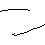

In [8]:
import PIL
import PIL.Image

equal_sign = list(data_dir.glob('=/*'))
PIL.Image.open(str(equal_sign[10]))

In [9]:
batch_size = 32
img_height = 45
img_width = 45

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.


2022-06-01 16:44:55.957161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [12]:
class_names = tuple(train_ds.class_names)
print(class_names)

('!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}')


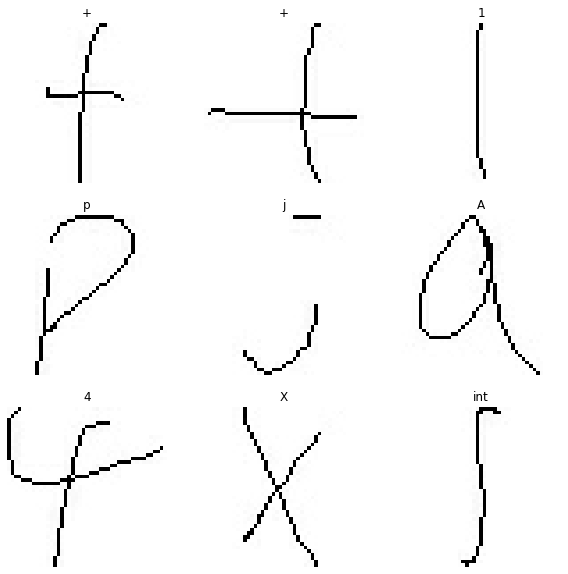

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 45, 45, 3)
(32,)


In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
num_classes = 82

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
%%time
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
).history

Epoch 1/3
9400/9400 [==============================] - 567s 60ms/step - loss: 0.6240 - accuracy: 0.8265 - val_loss: 0.3982 - val_accuracy: 0.8815
Epoch 2/3
9400/9400 [==============================] - 481s 51ms/step - loss: 0.3311 - accuracy: 0.8981 - val_loss: 0.2992 - val_accuracy: 0.9070
Epoch 3/3
9400/9400 [==============================] - 480s 51ms/step - loss: 0.2684 - accuracy: 0.9157 - val_loss: 0.2674 - val_accuracy: 0.9159
CPU times: user 40min 47s, sys: 14min 7s, total: 54min 55s
Wall time: 25min 27s


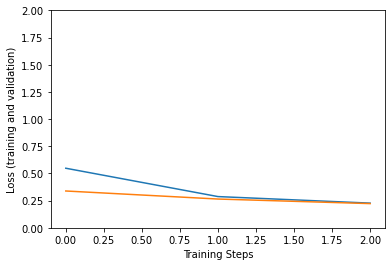

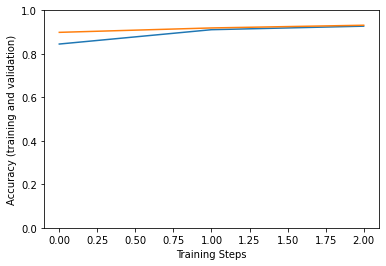

In [42]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 45, 45, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 43, 43, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


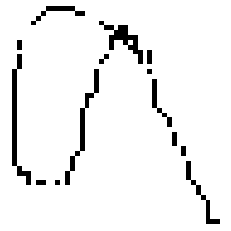

In [43]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

In [44]:
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

True label: !
Predicted label: A


In [46]:
print(prediction_scores)

[[-48.113712   -20.457277   -25.824167   -16.431799   -19.23765
  -19.443398    -1.3011963  -10.650194    -4.1425223  -13.875088
  -10.63277    -14.571105   -13.78982    -16.749878    -7.8607397
   -0.57645255 -23.82965     10.374161    -9.836652    -0.5170848
   -6.502877   -11.487779    -2.885098     3.538077    -0.3539524
   -9.272556   -13.084608    -0.198229   -40.666325   -40.464844
    8.19687    -40.964485    -2.9996846   -3.2116866   -5.4803715
   -8.966827   -32.03068     -8.293535   -29.82312    -16.25259
  -32.300266   -32.325058   -16.71548    -20.318922   -28.339308
  -15.960002   -30.501219     1.2365761  -43.205784   -23.76959
  -10.7762785  -11.136523   -13.069757   -55.5136     -27.17415
   -5.695961    -9.301744   -26.310207    -2.9346843  -37.1953
  -10.634852   -11.15749     -9.397061    -3.754564   -25.604258
  -25.31245     -5.795033   -35.333706   -15.25565    -13.497791
  -25.503317   -18.233444   -19.715788    -8.2320795   -8.148065
    3.223358    -4.1078997 

In [24]:
!pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-macosx_10_15_x86_64.whl (46.3 MB)


In [60]:
%load_ext autoreload
%autoreload 2
from get_test_data import test_data
import cv2

In [63]:
num=test_data("IMG_5023 copy 2.jpeg")[0]
array= np.array(num)
array.shape

(45, 45)

In [64]:
rgb = cv2.cvtColor(array, cv2.COLOR_GRAY2BGR)
rgb[:, :, 3] = rgb

IndexError: index 3 is out of bounds for axis 2 with size 3

In [44]:
rgbcopy = rgb.copy()

In [54]:
model.score

AttributeError: 'Sequential' object has no attribute 'score'

In [49]:
prediction_scores= model.predict(np.expand_dims(rgb, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

1/1 [==============================] - 0s 23ms/step
Predicted label: 7


In [ ]:
# https://www.tensorflow.org/tutorials/load_data/images